In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd ~
%cd /content/drive/My\ Drive/
%mkdir wgan-tutorial
%cd wgan-tutorial

#The heavy-lifting is done by the following repo
#!git clone https://github.com/gsbDBI/ds-wgan/
!pip install git+https://github.com/gsbDBI/ds-wgan

/root
/content/drive/My Drive
mkdir: cannot create directory ‘wgan-tutorial’: File exists
/content/drive/My Drive/wgan-tutorial
  Cloning https://github.com/gsbDBI/ds-wgan to /tmp/pip-req-build-okc2nk35
  Running command git clone --filter=blob:none --quiet https://github.com/gsbDBI/ds-wgan /tmp/pip-req-build-okc2nk35
  Resolved https://github.com/gsbDBI/ds-wgan to commit ee7fa679dfda852cdb04cef211f2370599e657b6
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/

In [3]:
import wgan
import torch
import pandas as pd
import numpy as np
import importlib
importlib.reload(wgan)
assert torch.cuda.is_available()

Training WGAN to emulate Lee (2008) data (Feel free to replace with any dataset of your choice)

In [4]:
# Generate X
cont1 = ["x"]
# Y | X
cont2 = ["y"]
text2 = ["x"]
lbound1 = {"x": -1}
ubound1 = {"x": 1}
lbound2 = {"y": 0}
ubound2 = {"y": 1}

df = pd.read_csv("./lee.csv")
dfa = df[df['x']>0].copy()
print(dfa.head())
dfb = df[df['x']<=0].copy()
#d= [64,64,64]
#dc=[128,128,128]
g_lr = 1e-4
c_lr = 1e-4
bsize = 128
opt = wgan.OAdam
g_opt = wgan.OAdam
cd = [128, 128, 128]
gd = [128, 128, 128]
factor = 5
noise = 2
dropout = 0.1
epochs = 2000
steps = 25

#oadam/oadam with batch size of 64 worked not bad
torch.manual_seed(0)
data_wrapper1 = wgan.DataWrapper(df, cont1, continuous_lower_bounds=lbound1,
                                              continuous_upper_bounds=ubound1)
x1,context1 = data_wrapper1.preprocess(df)
specs1 = wgan.Specifications(data_wrapper1,
                             batch_size=bsize,
                             max_epochs=801,
                             optimizer= torch.optim.Adam,
                             generator_optimizer = wgan.OAdam,
                             critic_lr=c_lr,
                             generator_lr = g_lr,
                             generator_d_noise = noise,
                             critic_d_hidden = cd,
                             generator_d_hidden = gd,
                             critic_gp_factor = factor,
                             generator_dropout = dropout,
                             critic_steps = steps,
                            print_every=100)
generator1 = wgan.Generator(specs1)
critic1 = wgan.Critic(specs1)

torch.manual_seed(0)
data_wrapper2a = wgan.DataWrapper(dfa, cont2, context_vars=text2, continuous_lower_bounds=lbound2,
                                              continuous_upper_bounds=ubound2)
x2a, context2a = data_wrapper2a.preprocess(dfa)
specs2a = wgan.Specifications(data_wrapper2a,
                              batch_size=bsize,
                              critic_steps=steps,
                              optimizer= torch.optim.Adam,
                              generator_optimizer = wgan.OAdam,
                              critic_lr = c_lr,
                              generator_lr = g_lr,
                              critic_d_hidden = cd,
                              generator_d_hidden = gd,
                              critic_gp_factor = factor,
                              generator_d_noise = noise,
                              generator_dropout = dropout,
                              max_epochs=901,
                              print_every=100)
generator2a = wgan.Generator(specs2a)
critic2a = wgan.Critic(specs2a)

torch.manual_seed(0)
data_wrapper2b = wgan.DataWrapper(dfb, cont2, context_vars=text2, continuous_lower_bounds=lbound2,
                                      continuous_upper_bounds=ubound2)
x2b, context2b = data_wrapper2b.preprocess(dfb)
specs2b = wgan.Specifications(data_wrapper2b,
                              batch_size=bsize,
                              critic_steps=steps,
                              optimizer=torch.optim.Adam,
                              generator_optimizer=wgan.OAdam,
                              critic_lr = c_lr,
                              generator_lr = g_lr,
                              critic_d_hidden = cd,
                              generator_d_hidden = gd,
                              critic_gp_factor = factor,
                              max_epochs = 1001,
                              generator_d_noise = noise,
                              generator_dropout= dropout,
                              print_every=100)
generator2b = wgan.Generator(specs2b)
critic2b = wgan.Critic(specs2b)

          x         y
0  0.104870  0.580962
1  0.139252  0.461058
3  0.086821  0.584580
4  0.399358  0.580286
5  0.168077  0.624352
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 25, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 2, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 801, 'batch_size': 128, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 25, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 2, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 901, '

/usr/local/lib/python3.11/dist-packages/wgan/wgan.py:66: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.stds  = [x.std(0,  keepdim=True) + 1e-5 for x in (continuous, context)]


In [5]:
wgan.train(generator1, critic1, x1, context1, specs1)
wgan.train(generator2a, critic2a, x2a, context2a, specs2a)
wgan.train(generator2b, critic2b, x2b, context2b, specs2b)

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.11/dist-packages/wgan/wgan.py:247: UserWarning: This overload of addcdiv_ is deprecated:
	addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcdiv_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  p.data.addcdiv_(step_size, exp_avg, exp_avg_sq.sqrt().add(group['eps']))


epoch 0 | step 53 | WD_test 0.18 | WD_train 0.12 | sec passed 10 |
epoch 100 | step 5253 | WD_test 0.08 | WD_train 0.08 | sec passed 34 |
epoch 200 | step 10453 | WD_test -0.17 | WD_train 0.01 | sec passed 34 |
epoch 300 | step 15653 | WD_test 0.24 | WD_train 0.11 | sec passed 33 |
epoch 400 | step 20853 | WD_test 0.18 | WD_train 0.09 | sec passed 33 |
epoch 500 | step 26053 | WD_test 0.1 | WD_train 0.06 | sec passed 33 |
epoch 600 | step 31253 | WD_test 0.16 | WD_train 0.04 | sec passed 34 |
epoch 700 | step 36453 | WD_test -0.14 | WD_train -0.02 | sec passed 33 |
epoch 800 | step 41653 | WD_test -0.0 | WD_train -0.02 | sec passed 33 |
epoch 0 | step 31 | WD_test 0.11 | WD_train 0.05 | sec passed 0 |
epoch 100 | step 3031 | WD_test 0.17 | WD_train 0.22 | sec passed 19 |
epoch 200 | step 6031 | WD_test 0.09 | WD_train 0.11 | sec passed 19 |
epoch 300 | step 9031 | WD_test 0.13 | WD_train 0.09 | sec passed 19 |
epoch 400 | step 12031 | WD_test -0.07 | WD_train 0.08 | sec passed 20 |
epo

In [6]:
%mkdir fake_Lee
def get_ground_truth():
    df = pd.DataFrame(np.zeros((10**6, 2)), columns=['x', 'y'])
    dfa = data_wrapper2a.apply_generator(generator2a, df)
    dfb = data_wrapper2b.apply_generator(generator2b, df)
    print(dfa.tail())
    print(dfb.tail())
    dfa.to_csv(f'./fake_Lee/dfa.csv', index=False)
    dfb.to_csv(f'./fake_Lee/dfb.csv', index=False)
    return dfa['y'].mean() - dfb['y'].mean()
np.random.seed(123)
get_ground_truth()

               y    x
999995  0.386743  0.0
999996  0.598048  0.0
999997  0.502789  0.0
999998  0.472252  0.0
999999  0.510614  0.0
               y    x
999995  0.402004  0.0
999996  0.472836  0.0
999997  0.489554  0.0
999998  0.507611  0.0
999999  0.298620  0.0


0.07856411

In [7]:
def apply_models_to_data():
    s = data_wrapper1.apply_generator(generator1, df)
    dfa = s[s['x']>0].copy()
    dfb = s[s['x']<=0].copy()
    dfa = data_wrapper2a.apply_generator(generator2a, dfa)
    dfb = data_wrapper2b.apply_generator(generator2b, dfb)

    return pd.concat([dfa,dfb],axis=0,ignore_index=True)

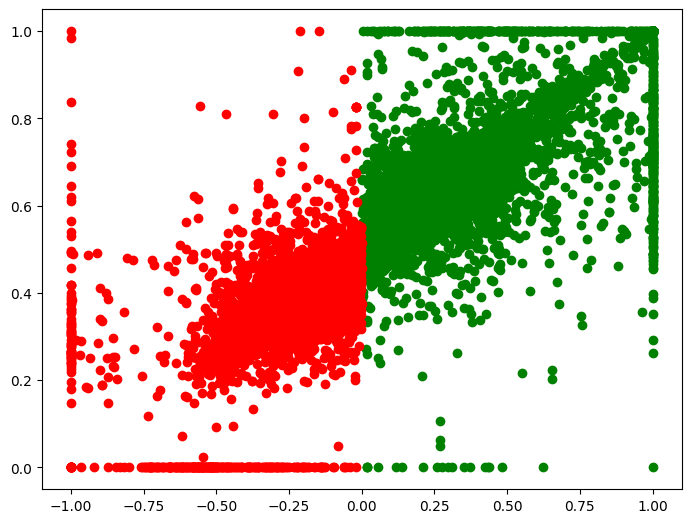

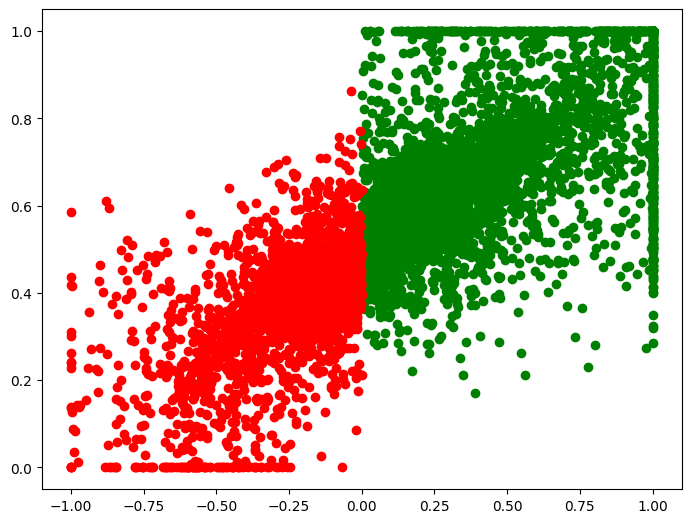

In [8]:
import matplotlib.pyplot as plt
df_fake = apply_models_to_data()

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(dfa['x'],dfa['y'], color='g')
ax.scatter(dfb['x'],dfb['y'], color='r')

fig2=plt.figure()
ax=fig2.add_axes([0,0,1,1])
ax.scatter(df_fake.loc[df_fake['x']>0,'x'],df_fake.loc[df_fake['x']>0,'y'], color='g')
ax.scatter(df_fake.loc[df_fake['x']<=0,'x'],df_fake.loc[df_fake['x']<=0,'y'], color='r')

In [10]:
# Repeat the process and save each replication as a separate csv file.
for i in range(1000):
  if(i % 50 == 0): print(i)
  df_fake = apply_models_to_data()
  df_fake.to_csv(f'./fake_Lee/df_fake_{i+1}.csv', index=False)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [9]:
# save trained model parameters
def save_trained_parameters(type):
  %mkdir trained_models
  for model, name in zip([generator1, critic1, generator2a, critic2a, generator2b, critic2b], ["Gx","Cx","Ga","Gb","Ca","Cb"]):
      torch.save(model.state_dict(), "./trained_models/" + name + "_{}.pth".format(type))
save_trained_parameters("lee")

mkdir: cannot create directory ‘trained_models’: File exists
